# Homework 5 - USA Airport Flight Analysis

Let's import all the libraries that we will need for this homework.

In [2]:
# Importing libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import plotly.express as px
import plotly.graph_objs as go
import dask.dataframe as dd
import folium
from folium import FeatureGroup, LayerControl
import seaborn as sns
import functions
from collections import defaultdict
import heapq

In [3]:
from importlib import reload
reload(functions)

<module 'functions' from 'c:\\Users\\matti\\Documents\\ADM\\HW5\\ADM_HW05\\functions.py'>

# Data Analysis

In [3]:
# Download Dataset
data = pd.read_csv(r"Airports2.csv")

Some information about our dataset.

In [4]:
# Viewing the data
data.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [5]:
# Describing the data
data.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [6]:
# Data types
data.dtypes

Origin_airport             object
Destination_airport        object
Origin_city                object
Destination_city           object
Passengers                  int64
Seats                       int64
Flights                     int64
Distance                    int64
Fly_date                   object
Origin_population           int64
Destination_population      int64
Org_airport_lat           float64
Org_airport_long          float64
Dest_airport_lat          float64
Dest_airport_long         float64
dtype: object

## Missing Values

In [7]:
# Checking for missing values
missing_values = data.isna().sum()
print(missing_values)

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


As we can see there are a lot of missing values when it comes to the coordinates of the airports. So we have to fill them.

In [8]:
unique_airports = pd.concat([data['Origin_airport'], data['Destination_airport']]).unique()
print(f"Unique airports to process: {len(unique_airports)}")

Unique airports to process: 727


We are going to use the <strong> geopy </strong> library in order to find the coordainates of the airports 

In [9]:
# Initialize the geolocator
geolocator = Nominatim(user_agent="flight_network_analysis", timeout=10)

# Define a function to fetch coordinates
def fetch_coordinates(airport_code, retries=3):
    """
    Fetches the latitude and longitude for a given airport code.
    Retries in case of timeout.
    """
    for attempt in range(retries):
        try:
            location = geolocator.geocode(f"{airport_code} airport")
            if location:
                return location.latitude, location.longitude
        except GeocoderTimedOut:
            print(f"Retrying for {airport_code}... (Attempt {attempt + 1})")
            time.sleep(1)  # Delay before retry
    return None, None  # If all retries fail

In [10]:
# Create a DataFrame to store airport coordinates
airport_coordinates = pd.DataFrame(unique_airports, columns=['Airport'])
airport_coordinates['Latitude'] = None
airport_coordinates['Longitude'] = None

In [11]:
# Fetch coordinates for all unique airports
for idx, airport in airport_coordinates.iterrows():
    lat, long = fetch_coordinates(airport['Airport'])
    airport_coordinates.at[idx, 'Latitude'] = lat
    airport_coordinates.at[idx, 'Longitude'] = long

In [12]:
# Create mapping dictionaries
lat_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Latitude']))
long_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Longitude']))

In [13]:
# Fill missing values
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(data['Origin_airport'].map(lat_mapping))
data['Org_airport_long'] = data['Org_airport_long'].fillna(data['Origin_airport'].map(long_mapping))
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(data['Destination_airport'].map(lat_mapping))
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(data['Destination_airport'].map(long_mapping))

After this process we will check again for missing values.

In [14]:
# Checking for any other missing values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      1163
Org_airport_long     1163
Dest_airport_lat     1147
Dest_airport_long    1147
dtype: int64


As we can see the missing values have decreased but we still have some. For these airports, we will create a manual dictionary which will have the lat and the long for each airport of the missing values.

In [15]:
# Identify missing origin airport codes
missing_origin_airports = data.loc[data['Org_airport_lat'].isna(), 'Origin_airport'].unique()
print(f"Missing Origin Airports: {missing_origin_airports}")

# Identify missing destination airport codes
missing_dest_airports = data.loc[data['Dest_airport_lat'].isna(), 'Destination_airport'].unique()
print(f"Missing Destination Airports: {missing_dest_airports}")

Missing Origin Airports: ['DQF' 'KY5' 'HIK' 'ESF' 'VWL' 'XXW' 'FVS' 'HLM' 'JSE' 'TN6' 'AIY' 'JRA'
 'JRB' 'TSS' 'WQM' 'KY1' 'IN1' 'TN3' 'OH5' 'KY3' 'OH3' 'VWT' 'WV1' 'OH2'
 'VWH' 'MI2' 'VWD' 'NY3' 'LSD' 'DQU' 'LWF' 'JZU' 'STF' 'TX6' 'OH1' 'DQC'
 'CGX']
Missing Destination Airports: ['IN1' 'TX6' 'JSE' 'AWX' 'VWL' 'CGX' 'VWD' 'HLM' 'MI2' 'LJY' 'VWH' 'NY3'
 'DQF' 'FVS' 'KY1' 'HIK' 'TSS' 'JRA' 'JRB' 'UXJ' 'XWL' 'TN6' 'ZXX' 'DQU'
 'XXW' 'TN3' 'LSD' 'NZJ' 'ESF' 'WV1' 'OH5' 'STF' 'OH3' 'WQM' 'LWF' 'KY5'
 'AIY' 'JCC' 'KY3' 'OH1']


In [16]:
# Creating the dictionary
manual_airport_coordinates = {
    'DQF' : (32.897480, -97.040443),  
    'KY5' : (37.5355556, -84.4072222),
    'HIK' : (21.32583333, -157.92166666),
    'ESF' : (31.395, -92.29583),
    'VWL' : (47.37611111, -94.79805555),
    'XXW' : (30.18055555, -82.57972222),
    'FVS' : (43.83388888,  -111.805),
    'HLM' : (42.79583, -86.16194),
    'JSE' : (58.30166666, -134.42444444),
    'TN6' : (35.99861111, -89.40611111),
    'AIY' : (39.3577777778, -74.46),
    'JRA' : (40.754626, -74.006808),
    'JRB' : (40.701116, -74.008801),
    'TSS' : (40.7425, -73.97194),
    'WQM' : (30.2125, -93.14333333),
    'KY1' : (37.56861111, -84.77222222),
    'IN1' : (41.30694444, -85.06416666),
    'TN3' : (35.50694444, -86.80361111),
    'OH5' : (39.24666666, -84.38888888),
    'KY3' : (38.058056, -83.979444),
    'OH3' : (39.44027777, -83.02305555),
    'VWT' : (32.11166666, -84.18833333),
    'WV1' : (38.29444444, -81.56555555),
    'OH2' : (40.3722222222, -83.8188888889),
    'VWH' : (31.9208333333, -102.3894444444),
    'MI2' : (42.74305555, -86.105),
    'VWD' : (36.31888888, -119.62972222),
    'NY3' : (42.45, -75.01638888),
    'LSD' : (38.09111111, -84.31666666),
    'DQU' : (55.77888888, -131.60138888),
    'LWF' : (35.23416666, -87.25805555),
    'JZU' : (42.89138888, -73.24638888),
    'STF' : (33.433056, -88.848611),
    'TX6' : (35.22202, -101.831642),
    'OH1' : (39.57027777, -83.42055555),
    'DQC' : (27.81277777, -80.49555555),
    'CGX' : (41.86, -87.6086111111),
    'AWX' : (32.32944444, -102.53027777),
    'UXJ' : (37.63138888, -84.33249999),
    'XWL' : (43.2125, -112.34583333),
    'ZXX' : (46.21833333, -119.20944444),
    'NZJ' : (33.67611, -117.73111),
    'JCC' : (37.8, -122.46666666),
    'LJY' : (37.64444444, -92.6525),
}

In [17]:
# Fill missing origin coordinates 
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Org_airport_long'] = data['Org_airport_long'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

# Fill missing destination coordinates  
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

Checking one more time for any missing values after applying the dictionary.

In [18]:
# Checking for any other missinf values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      0
Org_airport_long     0
Dest_airport_lat     0
Dest_airport_long    0
dtype: int64


In [19]:
# Save the dataset as a CSV, given the cleaning time is not very short, so I can reload it without having to reprocess it.
data.to_csv("AirportsClean.csv")
#data = pd.read_csv(r"AirportsClean.csv")

## Visualizing Data

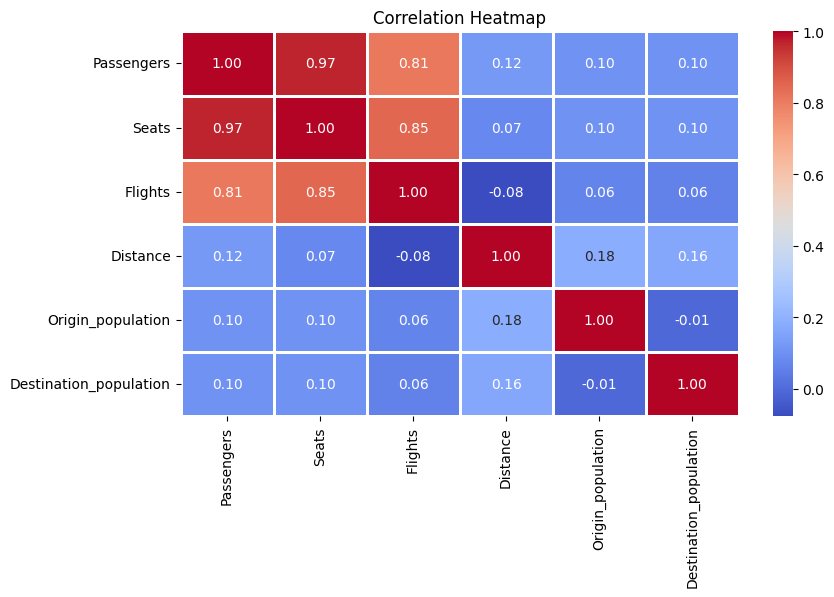

In [20]:
# Correlation Heatmap
numerical_columns = ['Passengers', 'Seats', 'Flights', 'Distance', 'Origin_population', 'Destination_population']
corr_matrix = data[numerical_columns].corr()

plt.figure(figsize=(9, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

# 1. Flight Network Analysis (Q1)

Before make the graph we have to find out if the graph is directed or undirected. So we are going to analyze how many routes are reciprocal (have both directions) and calculate the percentage. Let's set the threshold at 70%. So if reciprocity is >= 70% we will treat our graph as undirected. If not, we will treat our graph as directed.

In [5]:
# Group data to ensure unique routes
unique_routes = data[['Origin_airport', 'Destination_airport']].drop_duplicates()

# Create a set of routes and reverse routes
routes = set(tuple(x) for x in unique_routes.to_numpy())
reverse_routes = set((dest, origin) for origin, dest in routes)

# Count reciprocal routes
reciprocal_routes = routes.intersection(reverse_routes)
reciprocity = len(reciprocal_routes) / len(routes) if len(routes) > 0 else 0

print(f"Total Routes: {len(routes)}")
print(f"Reciprocal Routes: {len(reciprocal_routes)}")
print(f"Reciprocity: {reciprocity:.2%}")

Total Routes: 36719
Reciprocal Routes: 27188
Reciprocity: 74.04%


As we can see the reciprocity is 74.04%, so our graph will be a undirected one.

In [6]:
# Create graph
flight_network = nx.Graph()
    
# Add edges
for _, row in data.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    flight_network.add_edge(origin, destination)

## 1.2 Implement a function <strong> analyze_graph_features(flight_network) </strong>

Number of airports (nodes): 727
Number of flights (edges): 23260
Graph density: 0.0881


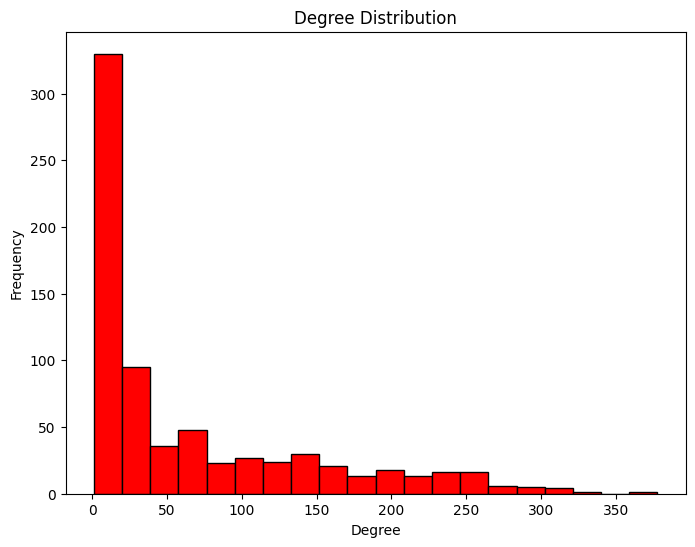

Hubs (airports with degree > 90th percentile): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'HSV', 'MIA', 'TPA', 'DAL', 'JAX']
The graph is sparse.


In [7]:
functions.analyze_graph_features(flight_network)

## 1.2 Write a function <strong> summarize_graph_features(flight_network) </strong>

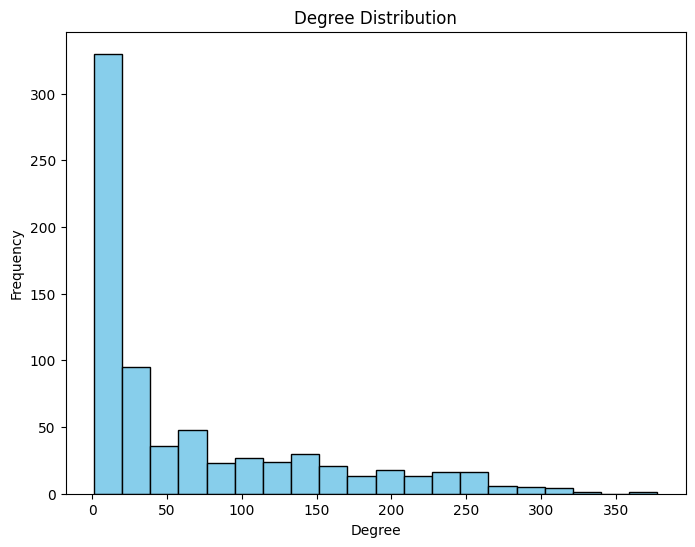


--- Graph Summary Report ---
Number of nodes: 727
Number of edges: 23260
Graph density: 0.08813911277335061

Hubs:
Airport  Degree
    YIP     378
    MSP     323
    MCI     319
    MEM     317
    ATL     308
    STL     304
    ORD     299
    MIA     299
    DFW     297
    IND     296
    OKC     290
    PHX     281
    SHV     280
    IAD     276
    DTW     272
    SLC     266
    LAS     266
    IAH     264
    MKE     264
    BWI     263
    LAX     262
    CLE     260
    ELP     259
    TUS     255
    JFK     255
    LIT     254
    EWR     252
    BNA     252
    CVG     252
    MDW     251
    PHL     250
    PIT     248
    RFD     247
    BOS     244
    CLT     244
    LRD     244
    ICT     243
    SAT     243
    MCO     241
    DAY     240
    RDU     239
    CMH     238
    SEA     235
    MSY     234
    DAL     234
    TUL     233
    TYS     230
    SFO     230
    OMA     229
    FLL     226
    BUF     225
    ABQ     223
    AUS     220
    OAK     219
    

{'Number of nodes': 727,
 'Number of edges': 23260,
 'Graph density': 0.08813911277335061,
 'Hubs':    Airport  Degree
 55     YIP     378
 29     MSP     323
 27     MCI     319
 33     MEM     317
 46     ATL     308
 ..     ...     ...
 42     HOU     200
 56     LGA     199
 49     GSO     198
 72     JAX     198
 68     HSV     197
 
 [73 rows x 2 columns]}

In [8]:
functions.summarize_graph_features(flight_network)

## 1.3 Deeper analysis of the dataset

Compute total passenger flow between origin and destination cities.

In [9]:
# Compute total passengers for each route
passenger_flow = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
passenger_flow = passenger_flow.rename(columns={'Passengers': 'Total_Passengers'})
passenger_flow

,Origin_airport,Destination_airport,Total_Passengers
0,1B1,BDL,1
1,ABE,ABE,2524
2,ABE,ACT,0
3,ABE,ACY,73
4,ABE,ADS,0
...,...,...,...
36714,YUM,YUM,0
36715,ZZV,MCI,0
36716,ZZV,PDK,0
36717,ZZV,SHV,0


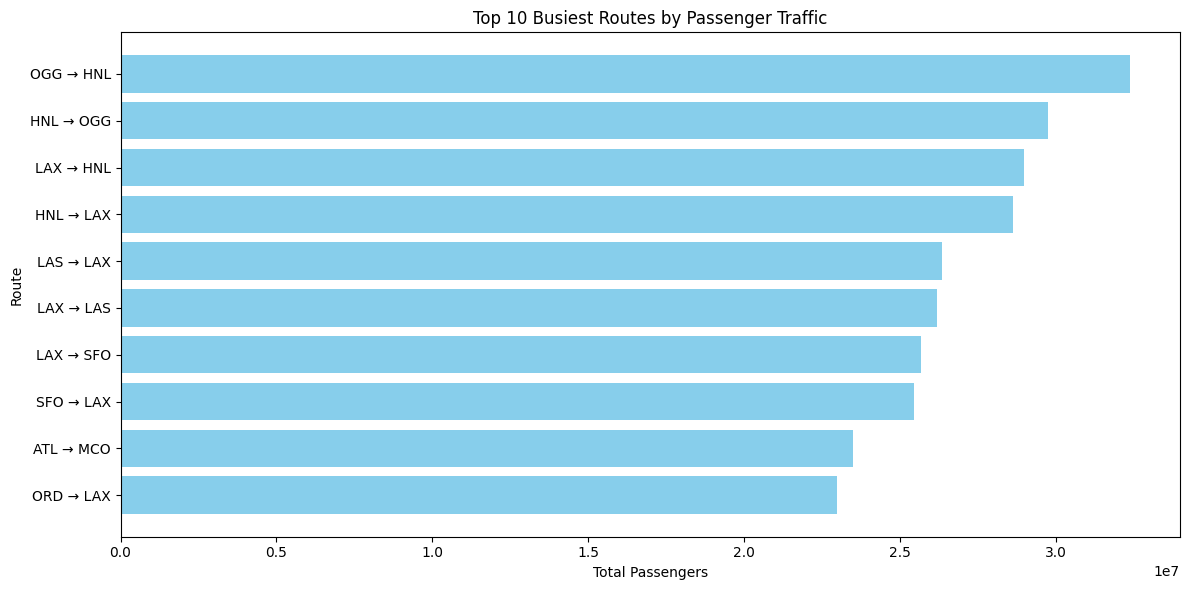


Top 10 Busiest Routes (Table):
Origin_airport Destination_airport  Total_Passengers
           OGG                 HNL          32364612
           HNL                 OGG          29744742
           LAX                 HNL          28964154
           HNL                 LAX          28632161
           LAS                 LAX          26333721
           LAX                 LAS          26177809
           LAX                 SFO          25661782
           SFO                 LAX          25458207
           ATL                 MCO          23483751
           ORD                 LAX          22979359


In [10]:
# Identify top 10 busiest routes
busiest_routes = passenger_flow.sort_values(by='Total_Passengers', ascending=False).head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(
    busiest_routes.apply(lambda x: f"{x['Origin_airport']} → {x['Destination_airport']}", axis=1),
    busiest_routes['Total_Passengers'],
    color='skyblue'
)
plt.xlabel('Total Passengers')
plt.ylabel('Route')
plt.title('Top 10 Busiest Routes by Passenger Traffic')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the table of top 10 busiest routes
print("\nTop 10 Busiest Routes (Table):")
print(busiest_routes.to_string(index=False))  

In [11]:
# Compute average passengers per flight
data['Avg_Passengers_Per_Flight'] = data['Passengers'] / data['Flights']

# Compute seat utilization for each route
data['Seat_Utilization'] = (data['Passengers'] / data['Seats']) * 100

# Classify routes as under-utilized or over-utilized
data['Utilization_Class'] = data['Seat_Utilization'].apply(
    lambda x: 'Under-utilized' if x < 70 else 'Over-utilized'
)
utilization_analysis = data[['Origin_airport', 'Destination_airport', 'Avg_Passengers_Per_Flight', 'Seat_Utilization', 'Utilization_Class']]
utilization_analysis

,Origin_airport,Destination_airport,Avg_Passengers_Per_Flight,Seat_Utilization,Utilization_Class
0,MHK,AMW,21.000000,70.000000,Over-utilized
1,EUG,RDM,1.863636,10.353535,Under-utilized
2,EUG,RDM,4.631579,25.730994,Under-utilized
3,EUG,RDM,2.750000,15.277778,Under-utilized
4,MFR,RDM,0.000000,0.000000,Under-utilized
...,...,...,...,...,...
3606798,STL,TBN,5.509804,28.998968,Under-utilized
3606799,STL,TBN,4.537037,23.879142,Under-utilized
3606800,STL,TBN,5.417910,28.515318,Under-utilized
3606801,CGI,TBN,2.000000,10.526316,Under-utilized


Top routes by passenger efficiency (table and bar chart).

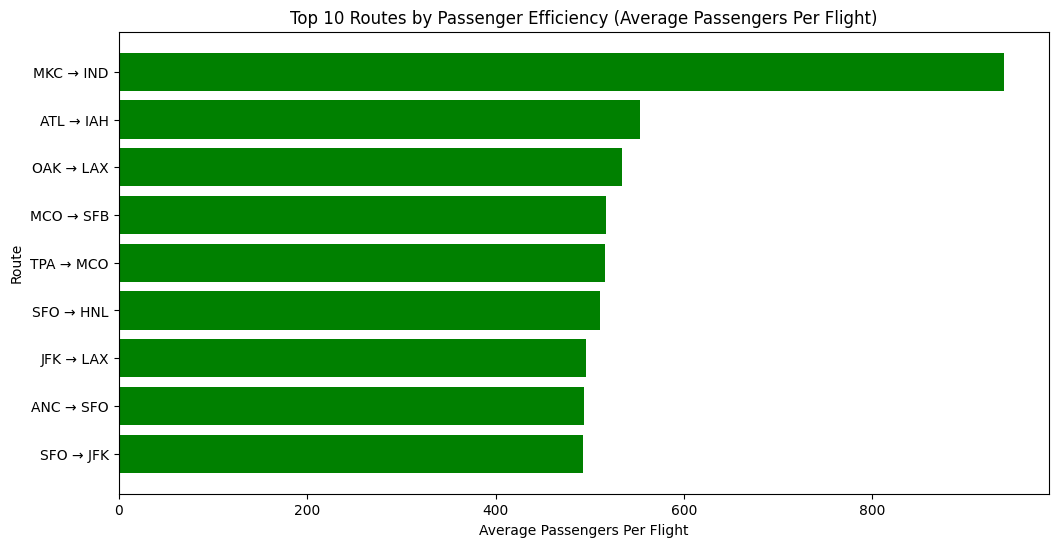

Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight):


,Origin_airport,Destination_airport,Passengers,Flights,Passenger_Efficiency
3256852,MKC,IND,940,1,940.000000
1040966,ATL,IAH,553,1,553.000000
2989778,OAK,LAX,534,1,534.000000
1340834,MCO,SFB,517,1,517.000000
1341272,TPA,MCO,516,1,516.000000
1639561,SFO,HNL,6644,13,511.076923
2977661,JFK,LAX,496,1,496.000000
3426967,ANC,SFO,494,1,494.000000
3426707,ANC,SFO,494,1,494.000000
1701095,SFO,JFK,493,1,493.000000


In [12]:
# Compute average passengers per flight
data['Passenger_Efficiency'] = np.where(
    data['Flights'] == 0, 
    0,  # Assign 0 efficiency if no flights
    data['Passengers'] / data['Flights']
)
    
# Sort by Passenger Efficiency and get top 10 routes
top_routes = data.sort_values(by='Passenger_Efficiency', ascending=False).head(10)
    
# Bar Chart for Passenger Efficiency
plt.figure(figsize=(12, 6))
plt.barh(
    top_routes.apply(
        lambda x: f"{x['Origin_airport']} → {x['Destination_airport']}", axis=1
    ),
    top_routes['Passenger_Efficiency'],
    color='green'
)
plt.xlabel('Average Passengers Per Flight')
plt.ylabel('Route')
plt.title('Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight)')
plt.gca().invert_yaxis()
plt.show()
    
# Display the table
print("Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight):")
display(top_routes[['Origin_airport', 'Destination_airport', 'Passengers', 'Flights', 'Passenger_Efficiency']])

Create an interactive map visualizing the geographic spread of the flight network.

In [13]:
# Read large CSV using Dask
ddf = dd.read_csv(r"Airports2.csv")
    
# Aggregate routes
route_aggregation = ddf.groupby([
    'Origin_airport', 
    'Destination_airport', 
    'Origin_city', 
    'Destination_city',
    'Org_airport_lat', 
    'Org_airport_long', 
    'Dest_airport_lat', 
    'Dest_airport_long'
    ])['Passengers'].sum().reset_index()
    
# Compute the aggregation
route_data = route_aggregation.compute()    

In [ ]:
 # Create interactive map
functions.create_flight_network_map(route_data)

### Due to the heaviness of the interactive map, this cell displays a screenshot of the result of the above function 'functions.create_flight_network_map(route_data)'; to interact with the map, you can run the notebook via the Google Colab link provided in the README file.

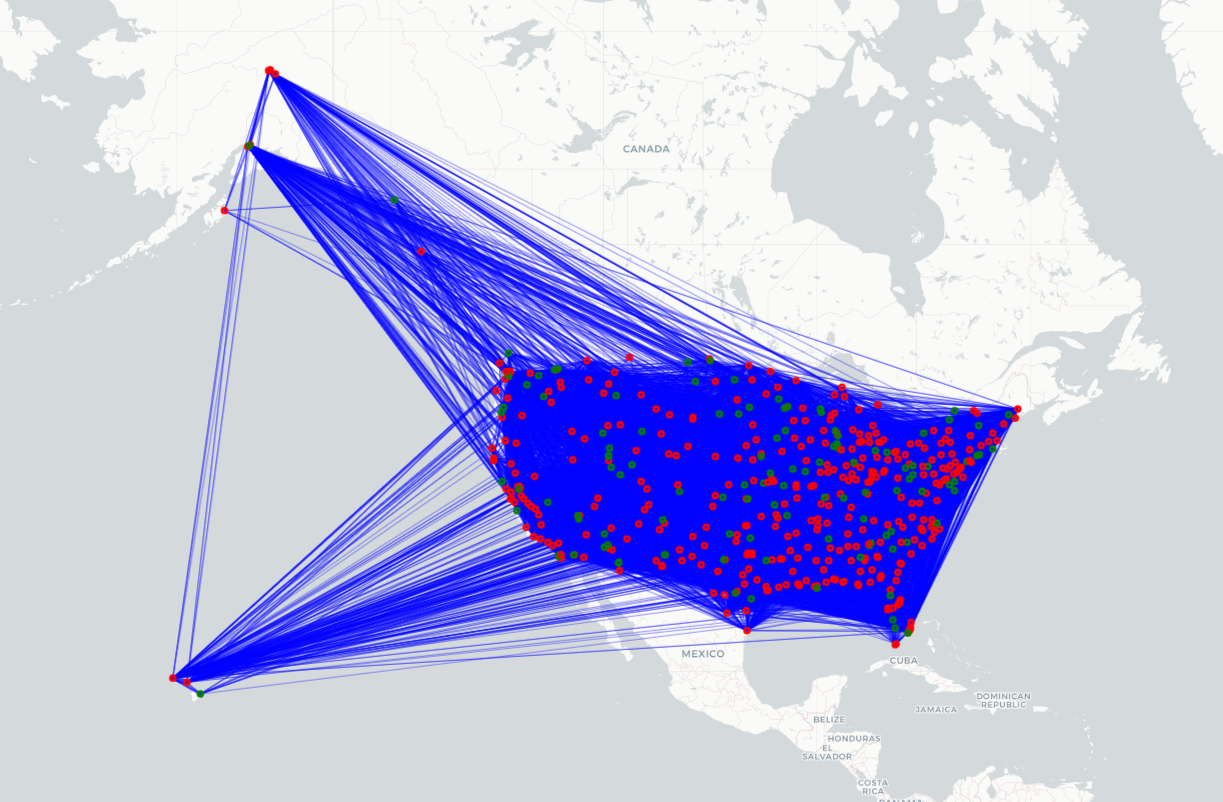

# 2. Nodes' Contribution (Q2)

In any network, certain nodes (airports) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.

In [37]:
df = pd.read_csv(r"AirportsClean.csv")

We don't need the entire dataset, so we create a DataFrame composed only of the columns Origin_airport, Destination_airport and Distance.
We notice that sometimes, for the same Origin_airport and Destination_airport pair, there are different distance values (likely due to measurement errors or changes in territories over time). 
To resolve this, we replace the distance value with the most frequent distance value (the mode) for each Origin_airport and Destination_airport pair using the function `build_df_for_network

In [38]:
# Save the resulting DataFrame from `build_df_for_network` in the variable `df_util`
df_util = functions.build_df_for_network(df)

# Construction of the directed graph with distances (for centrality measures, the distance will be used as the weight of the edges)
flight_network = functions.build_graph(df_util)

df_util.head()

,Origin_airport,Destination_airport,Distance
0,MHK,AMW,254
1,EUG,RDM,103
4,MFR,RDM,156
9,SEA,RDM,228
14,PDX,RDM,116


### Implement function `analyze_centrality(flight_network, airport)`

This function takes a graph and a node within it and returns the value of four centrality measures for that node:
- Betweenness centrality
- Closeness centrality
- Degree centrality
- PageRank

In our context, the graph represents flights from one airport to another, and the weights of the graph correspond to the distances between airports. 
The directed graph object is created using the function `build_graph`, which leverages the method `DiGraph` from the library **NetworkX**, starting from the previously cleaned dataset `df_util`.
For the calculation of each centrality measure, a separate function has been implemented, which will then be called by `analyze_centrality`.



In [39]:
input_airport = "YIP"
functions.analyze_centrality(flight_network, input_airport )

{'Betweenness Centrality': 0.32333452216274433,
 'Closeness Centrality': 0.00108300373460128,
 'Degree Centrality': 665,
 'PageRank': 0.011968947291634198}

### Implement function `compare_centralities(flight_network)`


This function: 

- Takes as input the same graph representing flights that we have been using so far.
- Calls the four implemented functions to calculate the respective centralities.
- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.


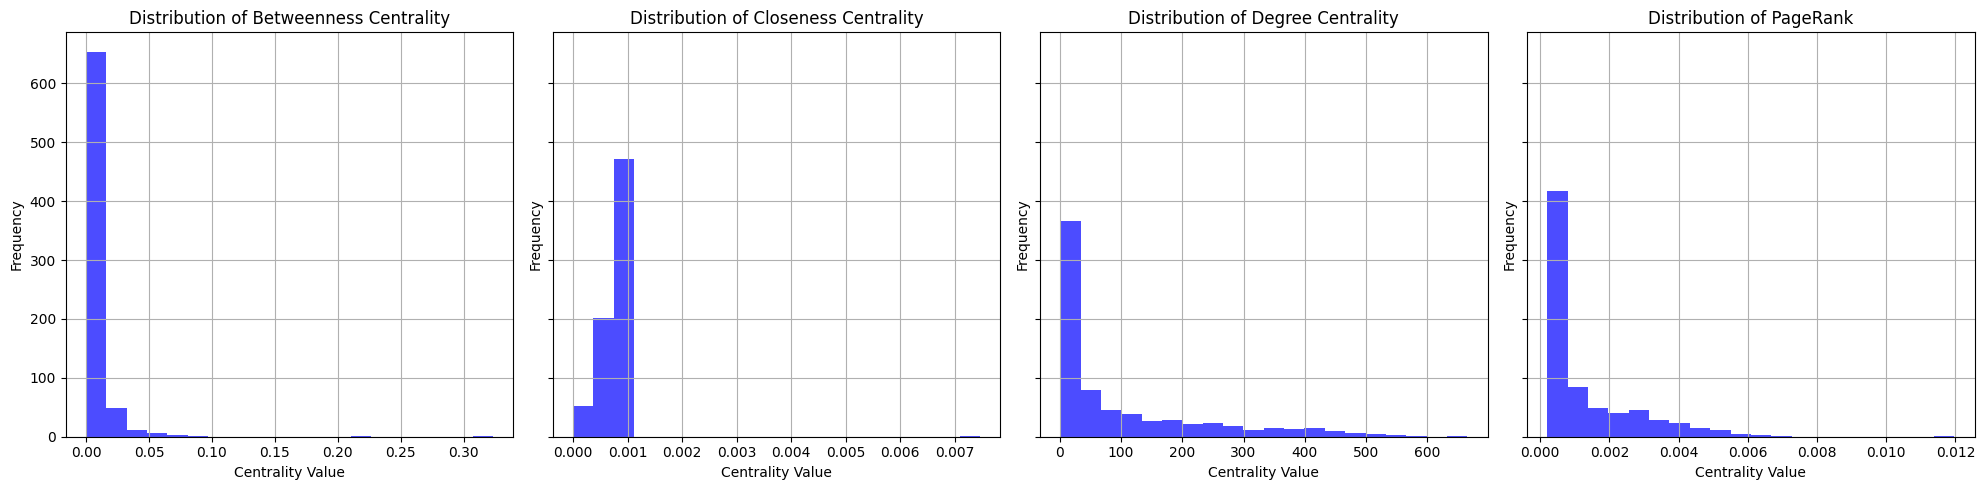

Top 5 airports for Betweenness Centrality: {'YIP': 0.32333452216274433, 'WFB': 0.3079985170796882, 'KTN': 0.21905510499998557, 'MTN': 0.0924843273053154, 'ATL': 0.07932240326645668}
Top 5 airports for Closeness Centrality: {'FVS': 0.007462686567164179, 'STL': 0.0010968246383736588, 'CMI': 0.0010956331194240101, 'DEC': 0.0010939293881731843, 'SPI': 0.001093278117891566}
Top 5 airports for Degree Centrality: {'YIP': 665, 'MSP': 583, 'MEM': 564, 'ATL': 539, 'MCI': 539}
Top 5 airports for PageRank: {'YIP': 0.011968947291634198, 'SHV': 0.007198937602747061, 'MSP': 0.007116248610591993, 'MEM': 0.006639978857497354, 'MCI': 0.006622748106211989}


In [40]:
top_airports = functions.compare_centralities(flight_network)
for centrality, airports in top_airports.items():
    print(f"Top 5 airports for {centrality}: {airports}")


## Interpretation of the Centrality Istogram

**Distribution of Betweenness Centrality**
  - Most nodes have a very low Betweenness Centrality value, close to 0.
  - Only a few nodes stand out with higher values, suggesting they are crucial for transit along the shortest paths in the network.
  - This pattern is typical of networks where only a few nodes act as critical hubs connecting different parts of the graph.

**Distribution of Closeness Centrality**
  - The distribution is strongly concentrated around very low values, with little variation among nodes.
  - This suggests that most airports are not "close" in terms of geodesic distance to others.
  - This indicates a small subset of well-positioned nodes in the network.

**Distribution of Degree Centrality**
  - The distribution shows a long tail, with most nodes having a low or moderate number of connections.
  - Only a few nodes have a significantly high number of connections.
  - This reflects a hierarchical structure typical of transport networks, with certain airports serving as key hubs.

**Distribution of PageRank**
  - Most nodes have PageRank values close to 0, while a minority have higher values.
  - The long tail suggests that only a few nodes are particularly influential in the network.
  - PageRank considers not just the number of connections but also their quality, which explains why some less connected airports can have high values.

---

## We Asked ChatGPT for Alternative Centrality Measures

ChatGPT suggested Eigenvector Centrality.

### What is Eigenvector Centrality?
Eigenvector Centrality measures the influence of a node in a network, considering not only the number of connections that node has but also the importance of the nodes it is connected to. In other words, a node is considered highly central if it is connected to many other central nodes.

### Why Could It Be Useful?
- **Hierarchical Importance:** It can help identify airports that not only have many connections but are also connected to other key airports in the network.
- **Transport Networks:** In airline transport networks, airports with high Eigenvector Centrality are often hubs or key nodes with high strategic importance.
- **Global Value:** Unlike other measures such as Degree Centrality, which counts only direct connections, this measure also considers the "weight" of neighboring nodes.


In [41]:
# Calculate Eigenvector Centrality using the NetworkX library, which we are already familiar with, so we can rely on it.
eigenvector_centrality = nx.eigenvector_centrality(flight_network, max_iter=100, tol=1e-6)
print(eigenvector_centrality)

{'MHK': 0.0433824135092604, 'AMW': 0.00032313986225523337, 'EUG': 0.03234107479521774, 'RDM': 0.01726538183634629, 'MFR': 0.019632827404545278, 'SEA': 0.07459341615275006, 'PDX': 0.0636019273127726, 'LMT': 0.0076188171813636315, 'SFO': 0.07015483383125637, 'LAX': 0.0838760849705984, 'EAT': 0.004011774817744721, 'YKM': 0.028004656601007656, 'EKO': 0.0578524891433649, 'SLE': 0.0037523930736894054, 'GEG': 0.05361650563242531, 'RDD': 0.01747665283986343, 'LWS': 0.022665366868510083, 'AST': 0.0014772303697703137, 'CLM': 0.0028431860778987458, 'PDT': 0.005066411771671053, 'SJC': 0.06525301421399266, 'ACV': 0.006918755502846352, 'PUW': 0.020500364016935436, 'SMF': 0.05325163128178413, 'FLL': 0.08359797844488895, 'PHX': 0.0893796948717969, 'BFI': 0.060122372323164856, 'GGG': 0.055420339515806744, 'GTF': 0.03912099745592324, 'FAT': 0.04740289762527906, 'TUS': 0.08276856233401954, 'MWH': 0.02296608531993188, 'BIL': 0.04767586290890842, 'DFW': 0.09850258545524858, 'RBG': 0.0010462856787560317, 'S

## To Verify the Correctness of the Results

- We can compare the results with the graph's topology:  
  - **Isolated nodes or nodes with few connections:** These should have a low or zero centrality value.  
  - **Hub or highly connected nodes:** These should have higher centrality values.  
  By doing this, we observe that this is indeed the case.

- Finally, we can also compare Eigenvector Centrality with other measures, such as **Degree Centrality;** nodes with high Eigenvector Centrality values should generally have high Degree Centrality values, though not always, as Eigenvector Centrality considers the importance of neighbors.  




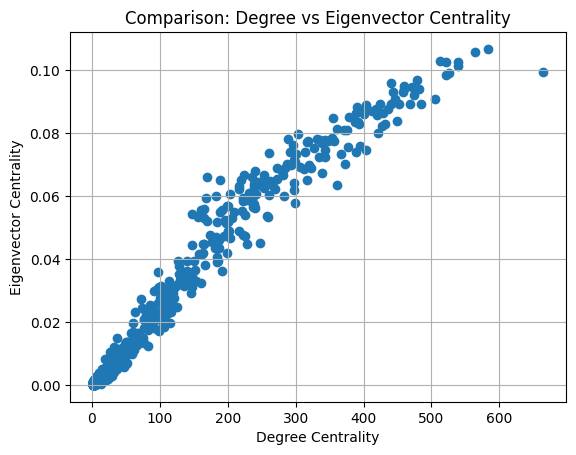

In [42]:
# Visual Comparison Between Degree Centrality and Eigenvector Centrality
degree_centrality_df = functions.calculate_degree_centrality(flight_network)  # DataFrame
degree_centrality = degree_centrality_df.set_index('Airport')['Total_degree']  # Extract Total_degree values

# Scatter plot
plt.scatter(degree_centrality.values, list(eigenvector_centrality.values()))
plt.title("Comparison: Degree vs Eigenvector Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
plt.grid(True)
plt.show()


### **Positive Linear Relationship**  
The graph shows an upward pattern (a cluster of points diagonally from the bottom left to the top right):  
- This means that nodes with a high number of connections (high Degree Centrality) also tend to have a high Eigenvector Centrality.  
- This typically occurs in graphs where the main hubs are interconnected (as in our case with airline networks featuring many flights between major hubs).  

### Now we can compare this new centrality measure with the four previously calculated.  
To do so, we will use the output of the `compare_centralities` function. Let’s see what comes out!

In [70]:
# Compare the results of the Eigenvector Centrality measure with the four previously calculated measures, 
# whose results were saved in the 'top_airports' dictionary 
# (for practicality, this comparison will be made for the top 5 airports with the highest values).

# Get the top 5 airports for Eigenvector Centrality
top_5_eigenvector = dict(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# Add the new centrality to the dictionary
top_airports['Eigenvector Centrality'] = top_5_eigenvector

# Print all centralities with the top 5 airports
for centrality, top_5 in top_airports.items():
    print(f"Top 5 airports for {centrality}:")
    for airport, value in top_5.items():
        print(f"  {airport}: {value}")
    print()

Top 5 airports for Betweenness Centrality:
  YIP: 0.32333452216274433
  WFB: 0.3079985170796882
  KTN: 0.21905510499998557
  MTN: 0.0924843273053154
  ATL: 0.07932240326645668

Top 5 airports for Closeness Centrality:
  FVS: 0.007462686567164179
  STL: 0.0010968246383736588
  CMI: 0.0010956331194240101
  DEC: 0.0010939293881731843
  SPI: 0.001093278117891566

Top 5 airports for Degree Centrality:
  YIP: 665
  MSP: 583
  MEM: 564
  ATL: 539
  MCI: 539

Top 5 airports for PageRank:
  YIP: 0.011968947291634195
  SHV: 0.007198937602747062
  MSP: 0.007116248610591994
  MEM: 0.006639978857497356
  MCI: 0.006622748106211989

Top 5 airports for Eigenvector Centrality:
  MSP: 0.10674817461884903
  MEM: 0.10569415266554277
  IND: 0.10281197138047611
  STL: 0.10269245362325259
  ATL: 0.10267595835715153



## Final Conclusions

#### **Betweenness Centrality** 
(This measure indicates how often an airport lies on the shortest paths between other airports)
- **Top 5 airports:** YIP, WFB, KTN, MTN, ATL.
  - **YIP (Willow Run Airport)** has the highest value, suggesting that it is a strategic airport for connecting other pairs of airports.
  - Other airports such as **WFB (Ketchikan Harbor Seaplane Base)** and **KTN (Ketchikan International Airport)** highlight how lesser-known airports can act as critical intermediate hubs.

---

#### **Closeness Centrality**
(This measure evaluates how "close" an airport is to others in terms of geodesic distance (shortest paths))
- **Top 5 airports:** FVS, STL, CMI, DEC, SPI.
  - **FVS** is the closest to other airports in the network.
  - **STL (St. Louis Lambert International Airport)** stands out here, suggesting that it is well-connected. It also appears in **Eigenvector Centrality**, confirming its importance.

---

#### **Degree Centrality**
(Measures the total number of connections (incoming and outgoing) for each airport)
- **Top 5 airports:** YIP, MSP, MEM, ATL, MCI.
  - **YIP (Willow Run Airport)** remains at the top, with the highest number of direct connections.
  - **MSP (Minneapolis–Saint Paul International Airport)**, **MEM (Memphis International Airport)**, and **ATL (Hartsfield-Jackson Atlanta International Airport)** prove to be hubs with many connections.

---

#### **PageRank**
(This measure considers not only the number of connections but also the importance of the nodes connected)
- **Top 5 airports:** YIP, SHV, MSP, MEM, MCI.
  - **YIP (Willow Run Airport)** remains the main node, but **SHV (Shreveport Regional Airport)** appears with a high value, suggesting that it is connected to important nodes despite having fewer connections.
  - **MSP, MEM**, and **MCI (Kansas City International Airport)** continue to demonstrate their strategic importance in the network.

---

#### **Eigenvector Centrality**
(Measures the importance of an airport based not only on the number of connections but also on the importance of the nodes to which it is connected)
- **Top 5 airports:** MSP, MEM, IND, STL, ATL.
  - **MSP (Minneapolis–Saint Paul)** has the highest value, showing that it is a hub connected to influential nodes.
  - **IND (Indianapolis International Airport)** and **STL** suggest that they are important in the network, even if they are not among the most central in other measures.

Eigenvector Centrality adds new insights, such as:
- **IND (Indianapolis)** emerges only in Eigenvector Centrality, suggesting that, despite having fewer direct connections compared to other airports, it is connected to highly influential nodes.
- **ATL** is present in almost all centralities, but in Eigenvector Centrality, its role is more prominent, indicating a strong connection to other influential hubs.


# 3. Finding Best Routes (Q3)
In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day


The function takes the following inputs:

    1. Flights network
    2. Origin city name
    3. Destination city name
    4. Considered Date (in yyyy-mm-dd format)

The function output:

    A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.

In [43]:
Date = data.groupby('Fly_date')['Origin_airport'].count().idxmax()
Date

'2007-12-01'

In [44]:

Origin_city = "Seattle"
Destination_city = "Bloomington"

In [45]:
graph = functions.build_transport_network(data)

The function build_transport_network creates a directed graph from a DataFrame, where airports are nodes with attributes like city, population, and location, and flights are edges with attributes such as distance, number of passengers, and flight date. It returns the constructed graph representing the fight network.

Compute_optimal_path() calls filter_network_by_date() to narrow down the network by the specified travel date, then uses compute_shortest_paths() to calculate the shortest route and trace_path() to construct the optimal flight path between the cities.

## compute_optimal_path(network_graph, start_city, end_city, travel_date)

Finds the shortest path between a starting city and an ending city on a specific travel date.
Filters the graph to include only flights relevant to the provided travel date.
Uses Dijkstra’s algorithm (via compute_shortest_paths) to find the shortest path between airports in the start and destination cities.

## filter_network_by_date(network, attribute, specific_date)

Filters the network graph to retain only the edges (flights) that match the specified date.
It creates and returns a new graph with the relevant edges and nodes for the given date.

## compute_shortest_paths(flight_network, starting_point)

Implements Dijkstra’s algorithm to compute the shortest path from a starting airport to all other airports in the network.
Returns two dictionaries: distances (the shortest distance to each node) and predecessors (the previous node in the path).

## trace_path(predecessors, destination, origin)

Reconstructs the path from the origin airport to the destination airport based on the predecessors dictionary.
It backtracks from the destination to the origin and returns the list of airports in the shortest path.



In [46]:
table = functions.compute_optimal_path(graph, Origin_city, Destination_city, Date)
table.head()

,Starting_City_Airport,Destination_City_Airport,Best_Route
0,Seattle,Bloomington,BFI→JFK→TCL→BDL→PWM→AVP→BMI


# 4. Airline Network Partitioning (Q4)

Since we are not going to use NetworkX library we have to convert our graph into a non-NetworkX approach. So we are going to convert it to an adjacency list.

In [15]:
# Convert the NetworkX graph to an adjacency list
adjacency_list = {}
for edge in flight_network.edges():
    origin, destination = edge
    if origin not in adjacency_list:
        adjacency_list[origin] = []
    if destination not in adjacency_list:
        adjacency_list[destination] = []
    adjacency_list[origin].append(destination)
    adjacency_list[destination].append(origin)

In [16]:
def find_bridges(adjacency_list):
    """
    Find all bridges in the graph represented as an adjacency list.
    A bridge is an edge that, if removed, disconnects the graph.
    """
    time = 0
    bridges = []
    visited = set()
    discovery_time = {}
    low_time = {}
    parent = {}

    def dfs(node):
        nonlocal time
        visited.add(node)
        discovery_time[node] = low_time[node] = time
        time += 1

        for neighbor in adjacency_list[node]:
            if neighbor not in visited:
                parent[neighbor] = node
                dfs(neighbor)

                # Update low value of the current node
                low_time[node] = min(low_time[node], low_time[neighbor])

                # Check if the edge is a bridge
                if low_time[neighbor] > discovery_time[node]:
                    bridges.append((node, neighbor))
            elif neighbor != parent.get(node):  # Back edge
                low_time[node] = min(low_time[node], discovery_time[neighbor])

    for node in adjacency_list:
        if node not in visited:
            dfs(node)

    return bridges

# Example usage:
bridges = find_bridges(adjacency_list)
print("Bridges:", bridges)

Bridges: [('MHK', 'AMW'), ('SCF', 'DWH'), ('TSS', 'WTC'), ('HIK', 'NZJ'), ('ILG', 'AL3'), ('CSV', 'TVI'), ('WFB', 'SLB'), ('HNL', 'AWX'), ('JNU', 'JSE'), ('RWI', 'RAC'), ('SUS', 'HBG'), ('TVC', 'MWC'), ('MSY', 'MHL'), ('MSY', 'MHE'), ('DET', 'ARB'), ('BHM', 'SME'), ('LGA', 'FCM'), ('BDL', '1B1'), ('GRR', 'OGB'), ('DRT', 'DUC'), ('MDW', 'JWN'), ('PIT', 'IDI'), ('ATL', 'AYS'), ('ACY', 'CRE'), ('MEM', 'ASL'), ('MEM', 'DTN'), ('MLU', 'BGD'), ('STL', 'FAM'), ('SPI', 'CGX'), ('SLN', 'MIW'), ('GRI', 'LXN'), ('VGT', 'MYF'), ('VGT', 'SEE'), ('SAT', 'NGP'), ('BGR', 'HUA'), ('YIP', 'SIK'), ('YIP', 'DMO'), ('YIP', 'OH5'), ('YIP', 'ATO'), ('YIP', 'OTM'), ('YIP', 'MEJ'), ('YIP', 'MUT'), ('YIP', 'PHD'), ('BOS', 'CUB'), ('BOS', 'MPS'), ('RFD', 'RVS'), ('RFD', 'PMH'), ('GCK', 'RSN'), ('MCI', 'DQC'), ('AFW', 'TDW'), ('LRD', 'MML'), ('LRD', 'UXJ'), ('SHV', 'ECG'), ('OAK', 'SNS'), ('TUL', 'SNL'), ('MIA', 'MIQ'), ('FBK', 'HCA'), ('ANC', 'MDD'), ('ANC', 'JCC'), ('ABQ', 'TSM'), ('ABQ', 'TX6'), ('SLC', 'XWL')

In [17]:
def remove_bridges(adjacency_list, bridges):
    """
    Remove the identified bridges from the adjacency list.
    """
    for u, v in bridges:
        adjacency_list[u].remove(v)
        adjacency_list[v].remove(u)

# Remove the bridges
remove_bridges(adjacency_list, bridges)